# Distributed XGBoost with Dask on CML

In this notebook we'll demonstrate a simple application of detecting credit card fraud by training a distributed XGBoost model using Dask, a library for scaling and parallelizing Python applications. Dask allows easy management of distributed workers and excels at handling large distributed data science workflows. The [XGBoost](https://github.com/dmlc/xgboost) package now includes Dask integration through two APIs: a functional interface (that we'll demonstrate here) and one that is modeled after Scikit-Learn. 


### Distributed computing
It's important to understand what we mean by "distributed" computing, since there are several paradigms for scaling machine learning workflows. 

**Memory-constrained.**
In this scenario the data is larger than can comfortably fit into memory and must instead be distributed across the nodes of your cluster. This necessitates distributing your ML model across those same nodes, a feature of ensemble models like XGBoost. This is the type of distributed computing we demonstrate in this notebook. 

**Compute-constrained.** 
In this scenario, the data fits in memory but the model size or training complexity is such that execution would simply take too long to complete in a reasonable time. This can happen, for example, when tuning a large model's hyperparameters or when performing cross validation. One way to handle this is to parallelize the computation, e.g., use each node in the cluster to train a separate set of hyperparameters for a given model. 


We do *not* perform this kind of distributed computing because, in our scenario, all the nodes in the cluster are already being used to handle the distributed data load! Instead, we perforrm hyperparameter tuning _sequentially_. We demonstrate how we roll our own quick and dirty hyperparameter tuning loop to handle this. 
 

### A note on the dataset
We'll work with a small sample of the credit card fraud dataset curated by the machine learning group at Université Libre de Bruxelles. The same group have a handbook detailing the application of machine learning for fraud detection, which provides considerably more depth than we do here. Creating a realistic fraud detection system is far too mighty a task for a single humble notebook, and so the dataset here serves only as an example for the purpose of demonstrating the technologies. Namely: parallelized training of XGBoost on a Dask cluster on CML. Throughout the process we'll also demonstrate how to use other supporting Dask libraries for a nearly end-to-end ML sa;laksfa;lskdfja;lskdfja


Code examples drawn in part from the [documentation](https://xgboost.readthedocs.io/en/stable/tutorials/dask.html) and [this blog post](https://medium.com/rapids-ai/a-new-official-dask-api-for-xgboost-e8b10f3d1eb7) published by RAPIDS AI, both excellent sources of information for further details. 

In [1]:
import cdsw
import seaborn as sns

import xgboost as xgb

from dask import dataframe as dd
from dask.distributed import Client
import dask_ml

from scipy.stats import uniform, loguniform, randint
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler # Use ParameterGrid for grid search
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
from tqdm import tqdm

from utils.dask_utils import run_dask_cluster

## Load Data

The data comes somewhat pre-engineered reduced, having gone through (at least) PCA. This was done in the name of privacy preservation, but also means the data is in reasonable shape to put directly into a supervised learning pipeline.

We begin by loading the data into a Dask DataFrame, which has much of the same functionality of a traditional Pandas Dataframe. Recall from the Dask Intro notebook that Dask performs _lazy_ execution so this DataFrame is not yet populated with values until explicit execution.

In [2]:
dask_df = dd.read_csv("data/creditcard.csv", assume_missing=True)

In [3]:
dask_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
dask_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


## Feature engineering

The task we perform here is a "point-like" prediction of fraud, in the sense that transactions are not linked by any id, so we can do no analysis of events from the same card over time. As such, each incoming datapoint will be subject to a prediction independent of the others. Time could be used as a feature, but only in the naive sense (time of day, etc). Neglecting time seems appropriate for this point-like prediction task.

In [3]:
dask_df = dask_df.drop(columns=['Time'])

The target class is heavily imbalanced -- this is expected since (hopefully) fraudulent transactions are a rare occurance!

In [8]:
class_counts = dask_df.Class.value_counts().compute()

print(f"""There are {class_counts[1]} identified cases of fraud in {class_counts.sum()} total cases. 
        That's only {100 * class_counts[1]/class_counts.sum():.2f}%!""")

There are 492 identified cases of fraud in 284807 total cases. 
        That's only 0.17%!


Maybe some features will be well correlated with the target. Let's do a visual spot check. Because there's such a huge class imbalance, we randomly downsample the dominant class to match the prevalence of the minority class.

In [4]:
sample_df = dd.concat([dask_df[dask_df.Class == 1], dask_df[dask_df.Class == 0].sample(frac=0.0017)]).compute().reset_index()

Now that we've created a small sample, we can convert this to a standard pandas dataframe for use in our plotting function. 

In [9]:
melted_cc = (
    sample_df
    .drop("Amount", axis="columns")
    .melt(id_vars=["Class"],
          value_vars=[c for c in dask_df.columns if c not in ["Class", "Amount"]])
)

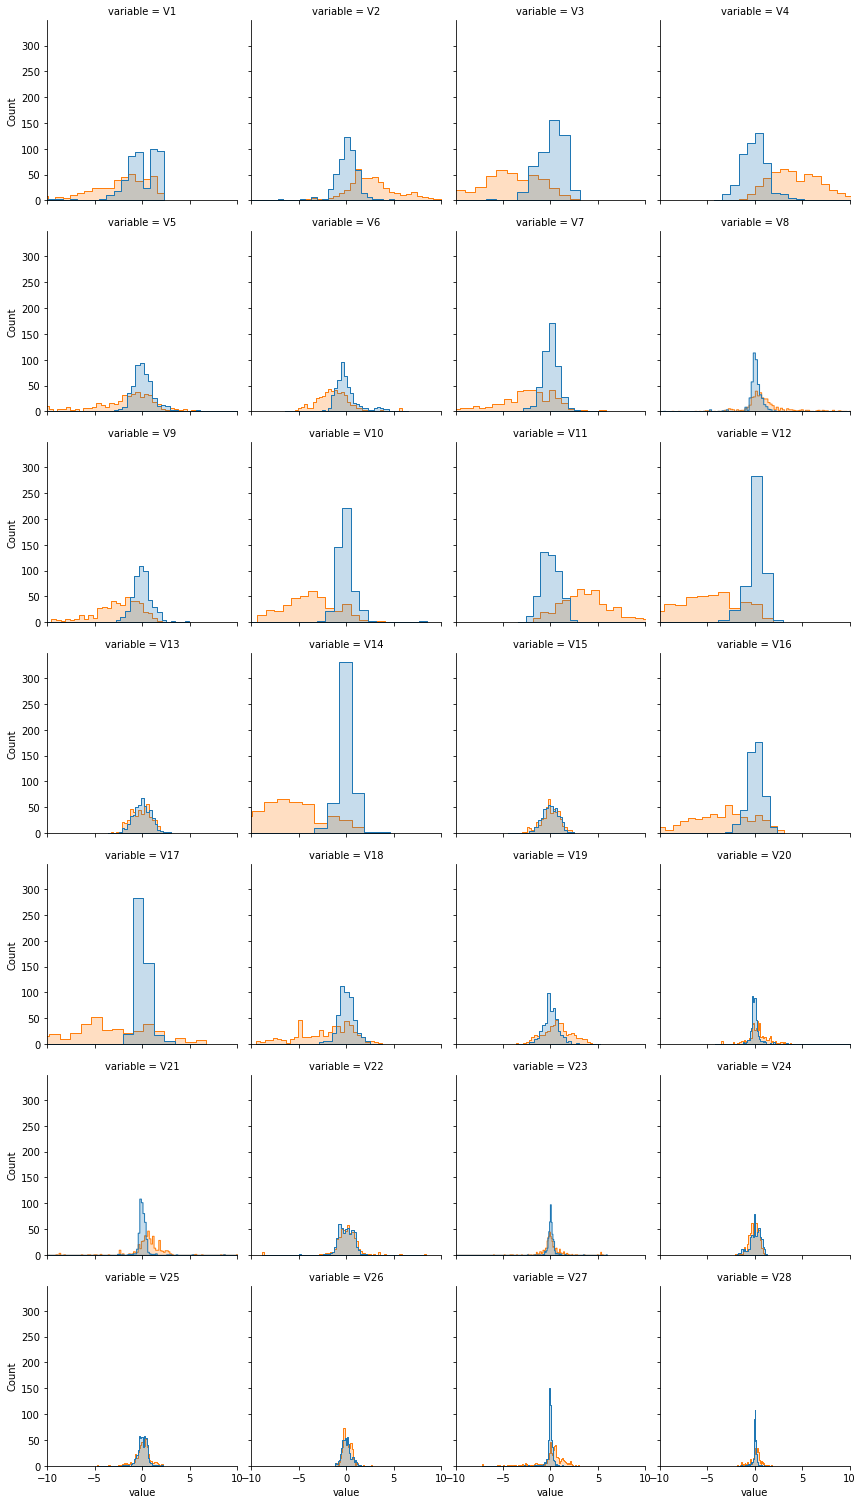

In [10]:
grid = sns.FacetGrid(melted_cc, col="variable", col_wrap=4)
grid.map_dataframe(sns.histplot, x="value", hue="Class", element="step")
grid.set(xlim=(-10,10))

It looks like there's some reasonable separation between fraudulent and non-fradulent transactions via some of the PCA feature distributions. This signals that there's a good chance we can learn to discriminate fraudulent transactions on the basis of these features. (Even those distributions that overlap extremely well may be useful in combination with other features). Keep in mind that that downsampling non-fraudulent transactions so severely introduces a lot of statistical noise - run the sampling repeatedly to draw new samples.

The scale of the `Amount` variable differs from the PCA variables above, so we plot it separately.

<AxesSubplot:xlabel='Amount', ylabel='Count'>

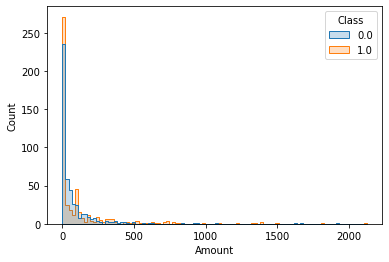

In [11]:
sns.histplot(
    sample_df,
    x="Amount", hue="Class", element="step", bins=100
)

We see that the features are not perfect standard normal distributions, but are all close to mean zero and standard deviation one, excepting the transaction amount. Taking all features `V1` through `V28` and `Amount` as our feature matrix, we can apply standard scaling to all (it will not harm those already scaled, and performance is not a concern).

## Train/dev/validation split

Before we compute anything, even baselines, let's establish a train test split. We'll do 70% train, 20% dev, and 10% validation. 

In [4]:
# Class is our target variable so we separate this column from the dask dataframe
y = dask_df['Class']
X = dask_df[dask_df.columns.difference(['Class'])]

In [5]:
X_train, X_dev, y_train, y_dev = dask_ml.model_selection.train_test_split(X, y, test_size=0.3, shuffle=True)
X_dev, X_val, y_dev, y_val = dask_ml.model_selection.train_test_split(X_dev, y_dev, test_size=0.333, shuffle=True)

Let's verify that our splits contain class imbalances that are approximately proportionally to our original dataset

In [7]:
print(y_train.sum().compute() / len(X_train.compute()))
print(y_dev.sum().compute() / len(X_dev.compute()))
print(y_val.sum().compute() / len(X_val.compute()))

0.0017783046828689982
0.0016253058371198882
0.001577784790154623


## Baselines Model
We should always start with some baseline classifiers, in order to gut-check whether our resulting (more sophisticated) model is sensible. 

### Dummy Classifier
A sensible baseline for binary classification is to always predict majority class. In our case, that means predicting nothing is fraud, everything is fine. That's gonna give us a heck of a good accuracy.

In [ ]:
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('majority_classifier', DummyClassifier(strategy="most_frequent"))
])

baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('majority_classifier',
                 DummyClassifier(strategy='most_frequent'))])

In [ ]:
print("Score on the train set:", baseline_pipeline.score(X_train, y_train))
print("Score on the dev set:", baseline_pipeline.score(X_dev, y_dev))

Score on the train set: 0.998229538125116
Score on the dev set: 0.9983818485621317


A better metric would be area under the PR curve. Maximizing this then allows us to choose an informed threshold (trading off precision and recall to suit the eventual application).

In [6]:
def area_under_pr_curve(classifier, X, y):
    precision, recall, _ = precision_recall_curve(classifier.predict(X), y)
    area = auc(recall, precision)
    return area

In [ ]:
area_under_pr_curve(baseline_pipeline, X_train, y_train)

/home/cdsw/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


nan

In [ ]:
(precision_score(y_train, baseline_pipeline.predict(X_train)),
 recall_score(y_train, baseline_pipeline.predict(X_train)))

/home/cdsw/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0)

But of course, this doesn't work. The area under our PR is not defined, because we always predict a single class - nothing varies with the threshold. Our precision for the one class is zero - we never predict the one class. Our precision for the zero class collapses to be simply the fraction of positive examples.

The good news is, we can probably improve on the baseline precision of 0 and recall of 0.

### Logistic Regression
Let's do the next most simple thing: logistic regression with no regularization.


In [22]:
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(penalty="none"))
])

In [23]:
logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_regression', LogisticRegression(penalty='none'))])

In [24]:
area_under_pr_curve(logistic_pipeline, X_train, y_train)

0.7896446578853034

In [25]:
area_under_pr_curve(logistic_pipeline, X_dev, y_dev)

0.6958413175686905

There we go -- some reasonable baselines that we can compare our XGBoost model against. It's time to up our ML game and compute! 

## Distributed XGBoost

So far, we've been using Dask DataFrames as a drop-in replacement for Pandas. Either can be used interchangeably in sklearn models, as we demonstrated above. These baseline models were run on the single CPU available to this notebook, since they required minimal (or no) training.  However, XGBoost is another story. It's time to see how we can use XGBoost+Dask to perform distributed training over multiple CPUs. 

First we spin up a Dask cluster using the `run_dask_cluster` function, which wraps together the steps we detailed in the Dask Intro notebook.  


In [7]:
NUM_WORKERS=2
CPU_PER_WORKER=1
MEM_PER_WORKER=2

In [8]:
dask_cluster = run_dask_cluster(num_workers=NUM_WORKERS, cpu=CPU_PER_WORKER, memory=MEM_PER_WORKER)

In [9]:
client = Client(dask_cluster['scheduler_address'])
client

<Client: 'tcp://100.66.128.5:8786' processes=2 threads=24, memory=3.69 GiB>

In [9]:
print("//".join(dask_cluster['scheduler'][0]["app_url"].split("//")) + "status")

https://3uxgi5ykbsdddrxj.fflab-4.cdsw-int.cloudera.com/status



XGBoost requires data in a specialized format called a DMatrix, a data object that has been optimized for memory efficiency. Below, we perform an operation that converts our Dask DataFrames to a Dask DMatrix. Under the hood, this process may place one or more DataFrame partitions onto one or more DMatrix objects. For large datasets, this may take some time because we are literally moving the data around the cluster we just spun up (which is why we pass it the dask `client`).

In [10]:
# X and y must be Dask dataframes or arrays
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train)
ddev = xgb.dask.DaskDMatrix(client, X_dev, y_dev)

Next we define some basic parameters for the XGBoost model, including a logistic objective function (since this is ultimately a classification problem), and the area under the PR curve evaluation metric. We also pass a list of evaluation datasets. For each round of boosting, the model will evaluate on whatever datasets are passed -- in this case, we include both the train and dev sets. 

In [47]:
eval_list = [(ddev,'dev'), (dtrain,'train')]
num_round = 5

params = {
    "verbosity": 2,
    "tree_method": "hist",
    "objective": "reg:logistic",
    "eval_metric": "aucpr"  
}

output = xgb.dask.train(client, params, dtrain, num_round, evals=eval_list)

In [48]:
output

{'booster': <xgboost.core.Booster at 0x7fba68378430>,
 'history': {'dev': OrderedDict([('aucpr',
                [0.7933187288028487,
                 0.8073171163414897,
                 0.8135432761784731,
                 0.8160643138848045,
                 0.8331958342476582])]),
  'train': OrderedDict([('aucpr',
                [0.8257486376337724,
                 0.8379667306320957,
                 0.8454408627529848,
                 0.8466568583907665,
                 0.8479261932361819])])}}

Discussion. 


### Hyperparameter tuning
stuff

In [18]:
def tune_xgboost(client, dtrain, params, search_space, num_samples, random_state=42):
    """
    Perform a random hyperparameter search for a distributed XGBoost model. 
    Returns the best model, best score, best parameters, and a Pandas DF containing 
    all hyperparameter tuning details. 
    
    Keyword arguments: 
    client -- Dask client
    dtrain -- training data in DaskDMatrix object
    params -- dict of XGBoost parameters that remain constant throughout hyperparameter tuning
    search_space -- dict of XGBoost parameters that will undergo random sampling
    num_samples -- number of random hyperparameter samples
    random_state -- random state initialization for the random hyperparameter sampling function
    """
    best_params, best_score, best_model = None, 0, None
    hp_results = list()
    
    try:
        num_round = params.pop("num_round")
    except KeyError:
        print("Number of boosting rounds missing! Please supply `num_round` to params")
        return

    try:
        eval_list = params.pop("eval_list")
    except KeyError:
        print("No `eval_list` data provided. Hyperparameter tuning will be scored on the train set.")
        eval_list = [(dtrain, "train")]

    for hp in tqdm(ParameterSampler(search_space, n_iter=num_samples, random_state=random_state)):
        params.update(hp)
        params_key = str(params)

        # Try to find new best model
        output = xgb.dask.train(client, params, dtrain, num_round, evals=eval_list)
        score = output["history"]["dev"]["aucpr"][-1]
        if score > best_score:
            best_params, best_score = params_key, score
            best_model = output["booster"]

        # Save history (scores) for reference
        hp["score"] = score
        for _, sample in eval_list:
            for metric in params["eval_metric"]:
                hp[f"{sample}_{metric}"] = output["history"][sample][metric]
        hp_results.append(hp)

        tqdm._instances.clear()  # jupyter notebook hack

    history_df = pd.DataFrame(hp_results)
    return {
        "best_model":best_model, 
        "best_params":best_params, 
        "best_score":best_score, 
        "hp_history":history_df
        }

In [ ]:
eval_list = [(ddev,'dev'), (dtrain,'train')]
eval_metrics = ["error", "aucpr"]

# These parameters will remain constant during the tuning process
params = {
    "verbosity": 2,
    "tree_method": "hist",
    "objective": "reg:logistic",
    "eval_metric": eval_metrics,
    # The following are not hyperparameters of the model but are used during training. 
    "eval_list": eval_list,  
    "num_round": 5
}

# These parameters will be tuned. 
search_space = {
    "learning_rate": uniform(0, 1),      # learning rate
    "gamma": loguniform(1e-6, 1e+1),     # minimum loss to make partition 
    "max_depth": randint(1, 20),         # max tree depth
    "min_child_weight": uniform(0, 10),  # min weight of node for further partitioning
    "max_delta_step": uniform(0, 10),    # max weight of each tree 
    "subsample": uniform(0, 1),          # subsample ratio of training examples
    "lambda": uniform(0, 1),            # L2 reg
    "alpha": uniform(0, 1),             # L1 reg
}

results = tune_xgboost(client, dtrain, params, search_space, num_samples=20)

 80%|██████████████████████████████████▍        | 16/20 [06:03<01:33, 23.33s/it]

In [37]:
results["best_model"]

In [45]:
results["hp_history"]

,alpha,gamma,lambda,learning_rate,max_delta_step,max_depth,min_child_weight,subsample,score,dev_error,dev_auc,dev_aucpr,train_error,train_auc,train_aucpr
0,0.374540,4.518561,0.731994,0.598658,1.560186,19,0.999749,0.459249,0.806670,"[0.00059849671706948, 0.00052808533859072, 0.0...","[0.8853551244115545, 0.8955385595920968, 0.905...","[0.7419359375823764, 0.7687644731755581, 0.779...","[0.00055595624474095, 0.0005759907040109, 0.00...","[0.8916259982729834, 0.9108409398266082, 0.916...","[0.7338067194543283, 0.7806093014046409, 0.786..."
1,0.333709,0.000010,0.650888,0.056412,7.219988,6,0.007788,0.992212,0.805326,"[0.00058089387244979, 0.00052808533859072, 0.0...","[0.9266617442046274, 0.926663213596281, 0.9266...","[0.7933913774276207, 0.7942255756206218, 0.802...","[0.00032555996313659, 0.00033557719277157, 0.0...","[0.9246457572900009, 0.9246478197655055, 0.924...","[0.8290418860727975, 0.8333109839558931, 0.842..."
2,0.617482,0.019124,0.007066,0.023062,5.247747,10,0.466657,0.973756,0.812734,"[0.00052808533859072, 0.00051048249397103, 0.0...","[0.935099542100826, 0.9357187070088145, 0.9477...","[0.8138190574041924, 0.820196801325775, 0.8133...","[0.00027046520014425, 0.00024041351123933, 0.0...","[0.9509330388341283, 0.9541706794357312, 0.966...","[0.894127946774915, 0.9073064293731018, 0.9137..."
3,0.232771,0.000004,0.618386,0.382462,9.832309,3,8.599404,0.680308,0.817505,"[0.00068651094016793, 0.00068651094016793, 0.0...","[0.9266112338665389, 0.9266520094849231, 0.926...","[0.7798016102279942, 0.7931967856768682, 0.804...","[0.00070120607444805, 0.00070621468926554, 0.0...","[0.9245626032944869, 0.9245810262175754, 0.924...","[0.769669385190038, 0.7768159514375979, 0.7894..."
4,0.450499,0.000001,0.942202,0.563288,3.854165,2,6.842330,0.440152,0.741376,"[0.00068651094016793, 0.00068651094016793, 0.0...","[0.8954046612776728, 0.9263136820567075, 0.926...","[0.6703762860056203, 0.7157868481994671, 0.737...","[0.00070120607444805, 0.00070120607444805, 0.0...","[0.896808302433827, 0.9242333039960129, 0.9243...","[0.6712171884974938, 0.720634235448863, 0.7347..."
5,0.122038,0.002926,0.034389,0.909320,2.587800,8,7.553614,0.425156,0.815172,"[0.00068651094016793, 0.00061609956168917, 0.0...","[0.9264040496433971, 0.9139680370580575, 0.940...","[0.7743407450546254, 0.8020062980849496, 0.812...","[0.00070120607444805, 0.00064110269663822, 0.0...","[0.9313026338871303, 0.9531795902775351, 0.966...","[0.769487543827144, 0.8065356590349387, 0.8284..."
6,0.207942,0.009417,0.031313,0.842285,4.497541,10,8.948274,0.597900,0.832994,"[0.00068651094016793, 0.00059849671706948, 0.0...","[0.9266182134768929, 0.937503099498019, 0.9381...","[0.7773848932179037, 0.8093708205368415, 0.833...","[0.00070120607444805, 0.00065111992627319, 0.0...","[0.9245633279480425, 0.9580591146729134, 0.969...","[0.7772404452486463, 0.821386087913317, 0.8408..."
7,0.921874,0.000004,0.195983,0.045227,3.253303,16,7.473201,0.539692,0.802322,"[0.00068651094016793, 0.00068651094016793, 0.0...","[0.9265700909002411, 0.9266463155922658, 0.926...","[0.7659391912873552, 0.785722166416966, 0.7986...","[0.00070120607444805, 0.00070120607444805, 0.0...","[0.9245490439116085, 0.9245878407481278, 0.924...","[0.7746499942453818, 0.793115644171962, 0.8023..."
8,0.586751,5.711986,0.607034,0.275999,2.962735,13,0.745506,0.986887,0.815063,"[0.00052808533859072, 0.00051048249397103, 0.0...","[0.8955288248723925, 0.8955339677431797, 0.895...","[0.7529712590215241, 0.7604670957651432, 0.760...","[0.00050086148174861, 0.00050587009656609, 0.0...","[0.8969483974760428, 0.8969649251513704, 0.896...","[0.7432915652563636, 0.7613853384874774, 0.761..."
9,0.772245,0.000025,0.005522,0.815461,7.068573,3,7.901755,0.605960,0.819665,"[0.00068651094016793, 0.00059849671706948, 0.0...","[0.9446459959995812, 0.9442413622730019, 0.944...","[0.7709314234064018, 0.797879973219332, 0.8167...","[0.00070120607444805, 0.00065111992627319, 0.0...","[0.9466159988900538, 0.9520753994220721, 0.952...","[0.772381342

In [21]:
results["best_params"]

"{'verbosity': 2, 'tree_method': 'hist', 'objective': 'reg:logistic', 'eval_metric': ['error', 'auc', 'aucpr'], 'alpha': 2.079416628681888, 'gamma': 0.009416777190511021, 'lambda': 0.31313292455558583, 'learning_rate': 0.8422847745949985, 'max_delta_step': 4.497541333697656, 'max_depth': 10, 'min_child_weight': 8.948273504276488, 'subsample': 0.5978999788110851}"

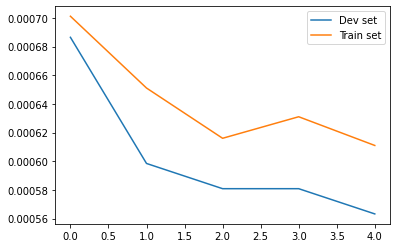

In [46]:
import matplotlib.pyplot as plt

history = results['hp_history']

plt.plot(history.iloc[history['score'].idxmax()]['dev_error'], label="Dev set")
plt.plot(history.iloc[history['score'].idxmax()]['train_error'], label="Train set")
plt.legend()

DISCUSSION


### Validation
Now that we have a tuned XGBoost model that's been trained on the train set and evaluated (during hyperparameter tuning) on the dev set, it's time to validate it on our final holdout - the validation set.

In [2]:
# read the model back in

# convert our validation set to a Dask DMatrix
dval = xgb.dask.DaskDMatrix(client, X_val, y_val)

In [23]:
prediction = xgb.dask.predict(client, output, dval)

In [24]:
pred = prediction.compute()

In [25]:
pred

array([0.02246135, 0.02246135, 0.02246135, ..., 0.02246135, 0.02246135,
       0.02246135], dtype=float32)

## Shut down workers

In [30]:
cdsw.stop_workers(*[worker["id"] for worker in dask_cluster['scheduler'] + dask_cluster['workers']])

[<Response [204]>, <Response [204]>, <Response [204]>]

2022-07-12 02:34:47,831 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***